# Utilities Module

Demonstrates the discrete geometry, linear algebra, and visualization utilities in `esapp.utils`.

Topics covered:
- 2D structured grids and finite difference operators
- Scalar and vector functions on grids
- Gradient, divergence, curl, and Laplacian operators
- Vector field visualization
- Unstructured meshes and graph Laplacians
- Spectral analysis utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from esapp.utils import (
    Grid2D, GridSelector,
    Mesh, extract_unique_edges,
    pathlap, pathincidence, normlap, eigmax, sorteig,
    hermitify, takagi, MU0,
    format_plot, plot_vecfield, darker_hsv_colormap,
)

## 1. Building a 2D Grid

The `Grid2D` class represents a structured rectangular grid and provides sparse matrix
operators for finite difference calculus. Points are indexed in column-major (Fortran) order.

In [2]:
nx, ny = 30, 30
grid = Grid2D((nx, ny))
sel = GridSelector(grid)

print(f"Grid shape: {grid.shape}")
print(f"Total points: {grid.size}")
print(f"Boundary points: {sel.boundary.sum()}")
print(f"Interior points: {sel.interior.sum()}")

Grid shape: (30, 30)
Total points: 900
Boundary points: 116
Interior points: 784


### Visualizing grid regions

`GridSelector` provides boolean masks for boundary and interior points.

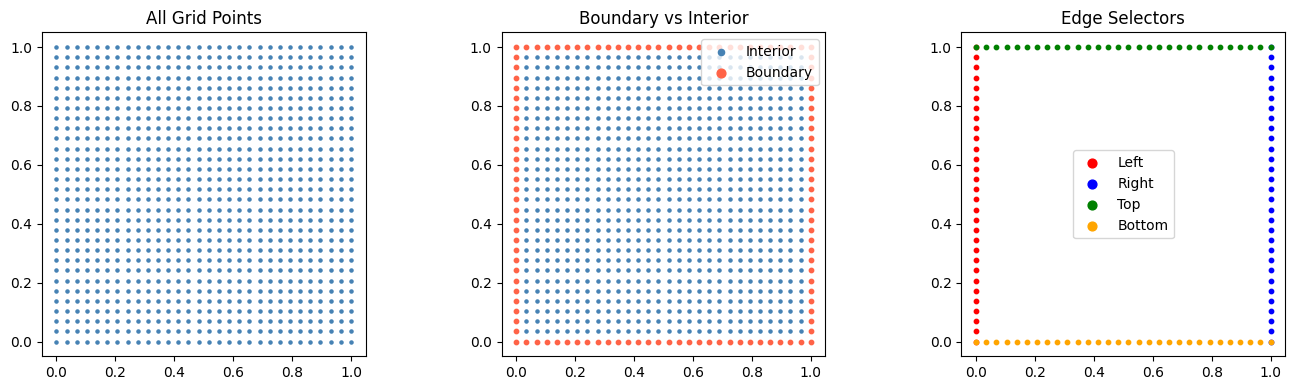

In [3]:
# Build coordinate arrays
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# All points
axes[0].scatter(X.ravel(order='C'), Y.ravel(order='C'), s=5, c='steelblue')
axes[0].set_title('All Grid Points')
axes[0].set_aspect('equal')

# Boundary vs interior
axes[1].scatter(X.ravel(order='C')[sel.interior], Y.ravel(order='C')[sel.interior],
                s=5, c='steelblue', label='Interior')
axes[1].scatter(X.ravel(order='C')[sel.boundary], Y.ravel(order='C')[sel.boundary],
                s=10, c='tomato', label='Boundary')
axes[1].set_title('Boundary vs Interior')
axes[1].set_aspect('equal')
axes[1].legend(markerscale=2)

# Edge selectors
axes[2].scatter(X.ravel(order='C')[sel.left], Y.ravel(order='C')[sel.left],
                s=10, c='red', label='Left')
axes[2].scatter(X.ravel(order='C')[sel.right], Y.ravel(order='C')[sel.right],
                s=10, c='blue', label='Right')
axes[2].scatter(X.ravel(order='C')[sel.top], Y.ravel(order='C')[sel.top],
                s=10, c='green', label='Top')
axes[2].scatter(X.ravel(order='C')[sel.bottom], Y.ravel(order='C')[sel.bottom],
                s=10, c='orange', label='Bottom')
axes[2].set_title('Edge Selectors')
axes[2].set_aspect('equal')
axes[2].legend(markerscale=2)

plt.tight_layout()
plt.show()

## 2. Scalar Functions on a Grid

Define a scalar field on the grid and visualize it.

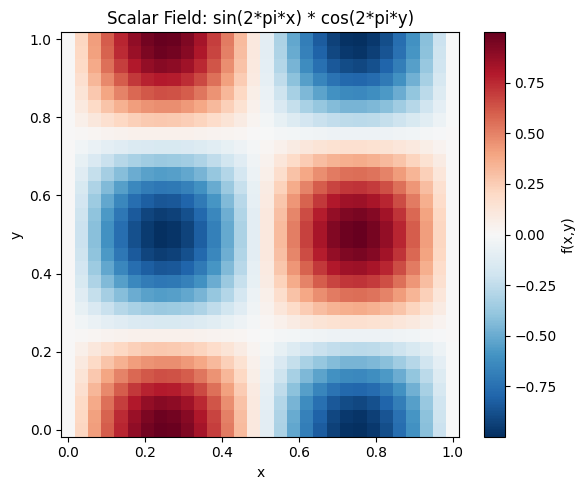

In [4]:
# Scalar field: f(x,y) = sin(2*pi*x) * cos(2*pi*y)
f = np.sin(2 * np.pi * X) * np.cos(2 * np.pi * Y)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.pcolormesh(X, Y, f, cmap='RdBu_r', shading='auto')
fig.colorbar(im, ax=ax, label='f(x,y)')
format_plot(ax, title='Scalar Field: sin(2*pi*x) * cos(2*pi*y)',
            xlabel='x', ylabel='y', grid=False, plotarea='white')
plt.tight_layout()
plt.show()

## 3. Gradient of a Scalar Field

The `Grid2D.gradient()` method returns sparse matrices `Dx` and `Dy` such that
the gradient of a scalar field `u` (flattened in Fortran order) is `(Dx @ u, Dy @ u)`.

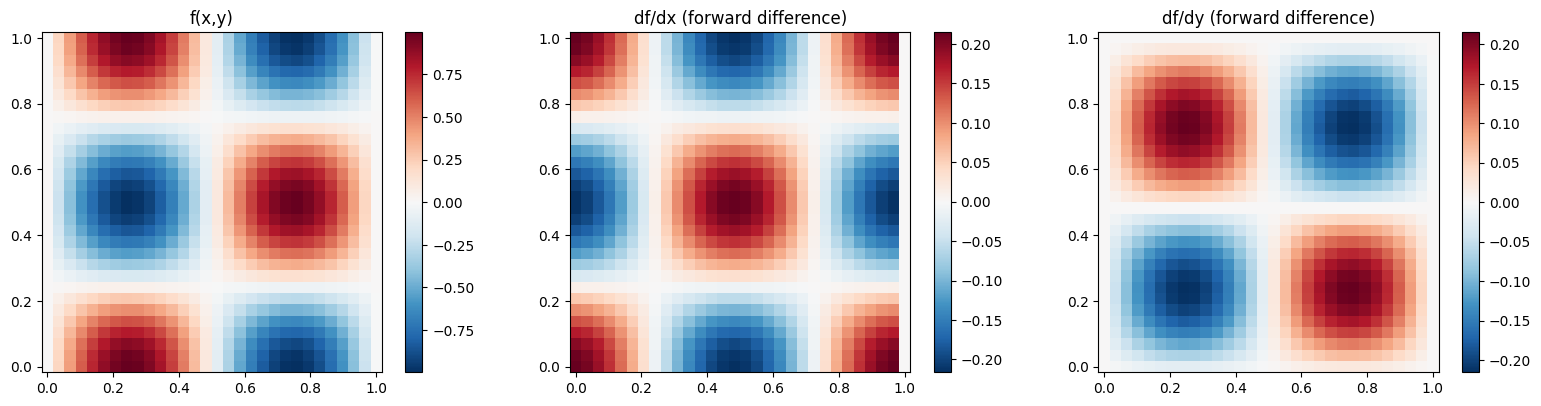

In [5]:
Dx, Dy = grid.gradient('forward')

# Flatten the scalar field in row-major order (matching grid indexing)
f_flat = f.ravel(order='C')

# Compute gradient components
grad_x = (Dx @ f_flat).reshape(ny, nx)
grad_y = (Dy @ f_flat).reshape(ny, nx)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

im0 = axes[0].pcolormesh(X, Y, f, cmap='RdBu_r', shading='auto')
fig.colorbar(im0, ax=axes[0])
axes[0].set_title('f(x,y)')
axes[0].set_aspect('equal')

im1 = axes[1].pcolormesh(X, Y, grad_x, cmap='RdBu_r', shading='auto')
fig.colorbar(im1, ax=axes[1])
axes[1].set_title('df/dx (forward difference)')
axes[1].set_aspect('equal')

im2 = axes[2].pcolormesh(X, Y, grad_y, cmap='RdBu_r', shading='auto')
fig.colorbar(im2, ax=axes[2])
axes[2].set_title('df/dy (forward difference)')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

### Gradient as a vector field

Plot the gradient vectors using `plot_vecfield`.

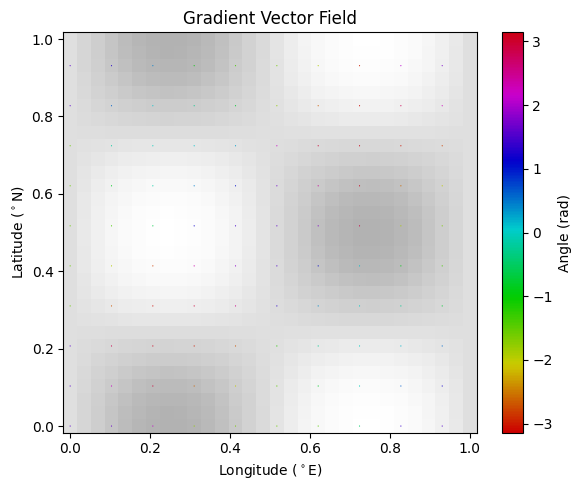

In [6]:
# Subsample for clearer arrows
step = 3
Xs = X[::step, ::step]
Ys = Y[::step, ::step]
Us = grad_x[::step, ::step]
Vs = grad_y[::step, ::step]

fig, ax = plt.subplots(figsize=(6, 5))
ax.pcolormesh(X, Y, f, cmap='Greys', shading='auto', alpha=0.3)
sm = plot_vecfield(ax, Xs, Ys, Us, Vs, scale=150, width=0.003,
                   title='Gradient Vector Field')
fig.colorbar(sm, ax=ax, label='Angle (rad)')
plt.tight_layout()
plt.show()

## 4. Divergence and Curl

Define a vector field and compute its divergence and curl using the grid operators.

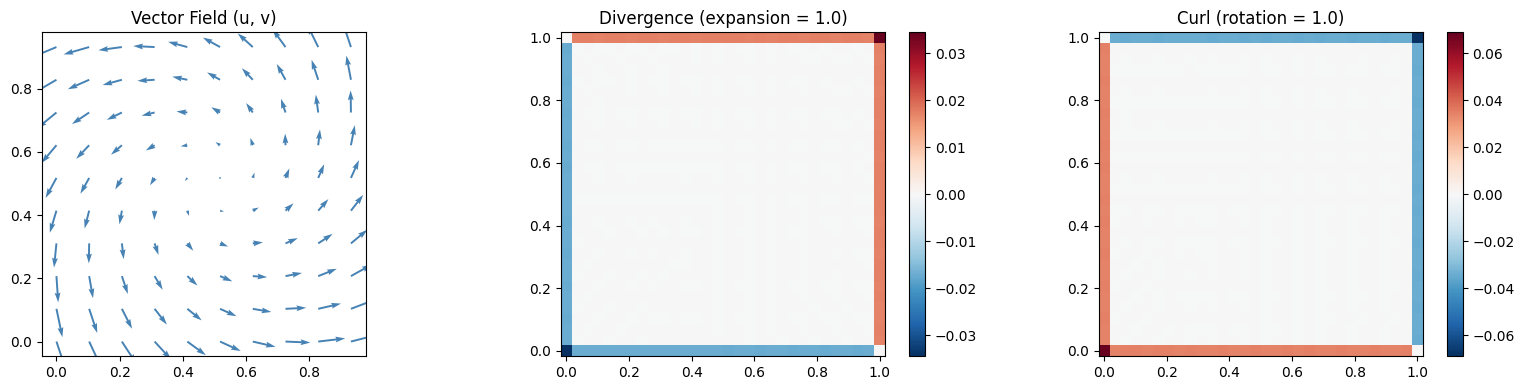

In [7]:
# Vector field: rotating + source
# u = -y + x,  v = x + y  (rotation + expansion)
Xc = X - 0.5  # center at (0.5, 0.5)
Yc = Y - 0.5
u_field = -Yc + 0.5 * Xc
v_field = Xc + 0.5 * Yc

# Stack as [u; v] vector
uv = np.concatenate([u_field.ravel(order='C'), v_field.ravel(order='C')])

# Compute divergence and curl
div_op = grid.divergence()
curl_op = grid.curl()

div_uv = (div_op @ uv).reshape(ny, nx)
curl_uv = (curl_op @ uv).reshape(ny, nx)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

step = 3
axes[0].quiver(X[::step, ::step], Y[::step, ::step],
               u_field[::step, ::step], v_field[::step, ::step],
               color='steelblue')
axes[0].set_title('Vector Field (u, v)')
axes[0].set_aspect('equal')

im1 = axes[1].pcolormesh(X, Y, div_uv, cmap='RdBu_r', shading='auto')
fig.colorbar(im1, ax=axes[1])
axes[1].set_title('Divergence (expansion = 1.0)')
axes[1].set_aspect('equal')

im2 = axes[2].pcolormesh(X, Y, curl_uv, cmap='RdBu_r', shading='auto')
fig.colorbar(im2, ax=axes[2])
axes[2].set_title('Curl (rotation = 1.0)')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

## 5. Discrete Laplacian

The grid Laplacian approximates the sum of second partial derivatives using the 5-point stencil.
This is equivalent to the combinatorial graph Laplacian L = D - A on the grid graph.

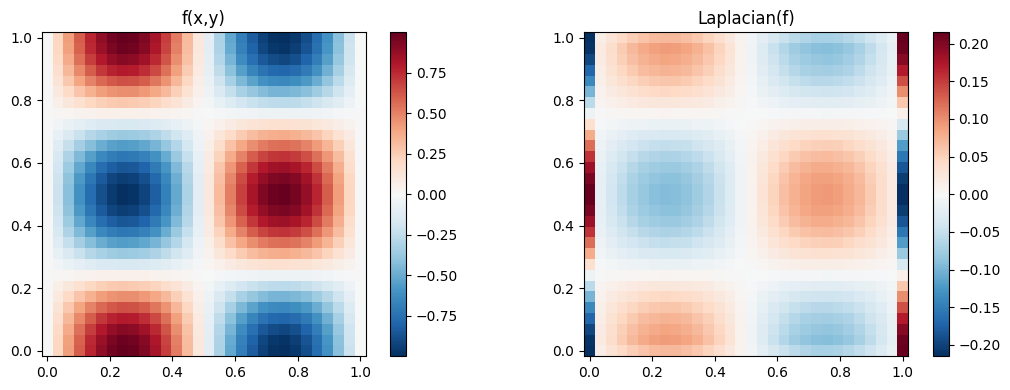

In [8]:
L = grid.laplacian()

# Apply Laplacian to our scalar field
lap_f = (L @ f_flat).reshape(ny, nx)

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

im0 = axes[0].pcolormesh(X, Y, f, cmap='RdBu_r', shading='auto')
fig.colorbar(im0, ax=axes[0])
axes[0].set_title('f(x,y)')
axes[0].set_aspect('equal')

im1 = axes[1].pcolormesh(X, Y, lap_f, cmap='RdBu_r', shading='auto')
fig.colorbar(im1, ax=axes[1])
axes[1].set_title('Laplacian(f)')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

### Verify: Grid2D Laplacian == Graph Laplacian (D - A)

The `Grid2D.laplacian()` computes `Dx.T @ Dx + Dy.T @ Dy`. We verify this equals the
standard combinatorial graph Laplacian `L = D - A` on the grid graph.

Grid2D.laplacian() == D - A: True


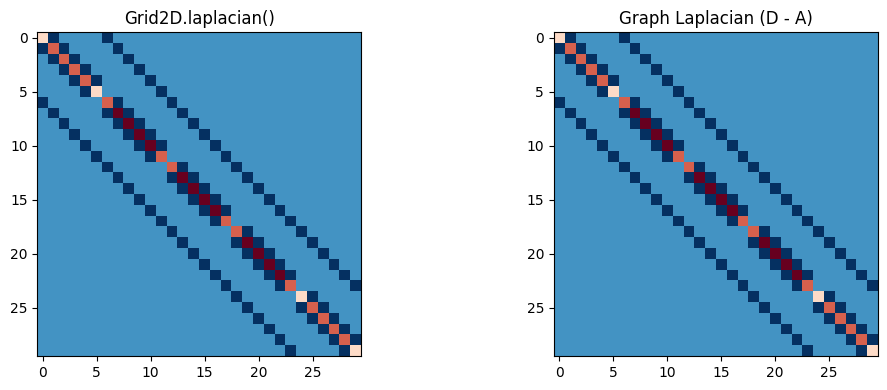

In [9]:
# Build graph Laplacian from scratch on a small grid
small = Grid2D((6, 5))
n = small.size
A = np.zeros((n, n))
for idx in range(n):
    x_i, y_i = idx % small.nx, idx // small.nx
    if x_i < small.nx - 1:  # right neighbor
        A[idx, idx + 1] = 1
        A[idx + 1, idx] = 1
    if y_i < small.ny - 1:  # top neighbor
        A[idx, idx + small.nx] = 1
        A[idx + small.nx, idx] = 1

D = np.diag(A.sum(axis=1))
L_graph = D - A
L_grid = small.laplacian().toarray()

print("Grid2D.laplacian() == D - A:", np.allclose(L_grid, L_graph))

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].imshow(L_grid, cmap='RdBu_r')
axes[0].set_title('Grid2D.laplacian()')
axes[1].imshow(L_graph, cmap='RdBu_r')
axes[1].set_title('Graph Laplacian (D - A)')
plt.tight_layout()
plt.show()

## 6. Hodge Star (90-degree Rotation)

The Hodge star operator rotates a vector field by 90 degrees. For a 2D field `[u; v]` it returns `[-v; u]`.

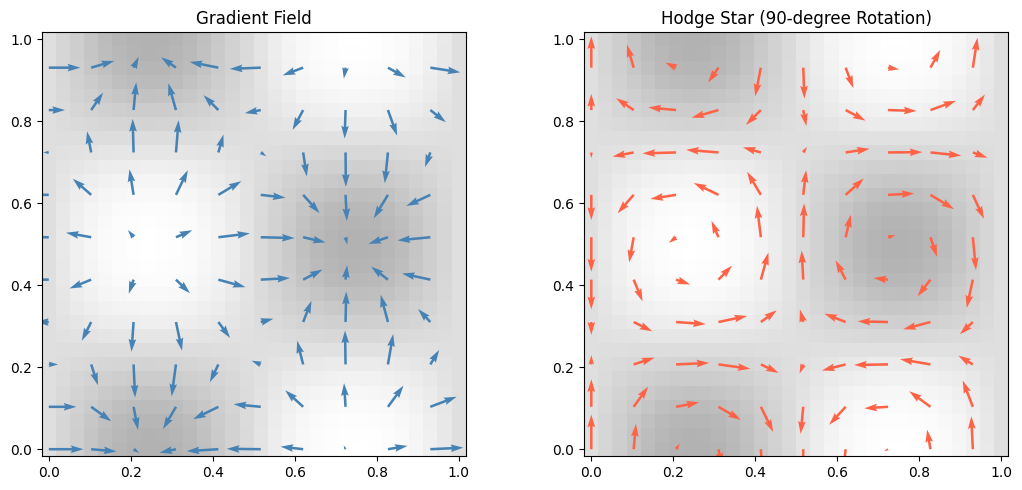

In [10]:
H = grid.hodge_star()

# Rotate the gradient field
grad_flat = np.concatenate([grad_x.ravel(order='C'), grad_y.ravel(order='C')])
rotated = H @ grad_flat
rot_x = rotated[:grid.size].reshape(ny, nx)
rot_y = rotated[grid.size:].reshape(ny, nx)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

step = 3
axes[0].pcolormesh(X, Y, f, cmap='Greys', shading='auto', alpha=0.3)
axes[0].quiver(X[::step, ::step], Y[::step, ::step],
               grad_x[::step, ::step], grad_y[::step, ::step], color='steelblue')
axes[0].set_title('Gradient Field')
axes[0].set_aspect('equal')

axes[1].pcolormesh(X, Y, f, cmap='Greys', shading='auto', alpha=0.3)
axes[1].quiver(X[::step, ::step], Y[::step, ::step],
               rot_x[::step, ::step], rot_y[::step, ::step], color='tomato')
axes[1].set_title('Hodge Star (90-degree Rotation)')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

## 7. Boundary Conditions with GridSelector

Use `GridSelector` masks to apply Dirichlet boundary conditions and solve a Poisson equation.

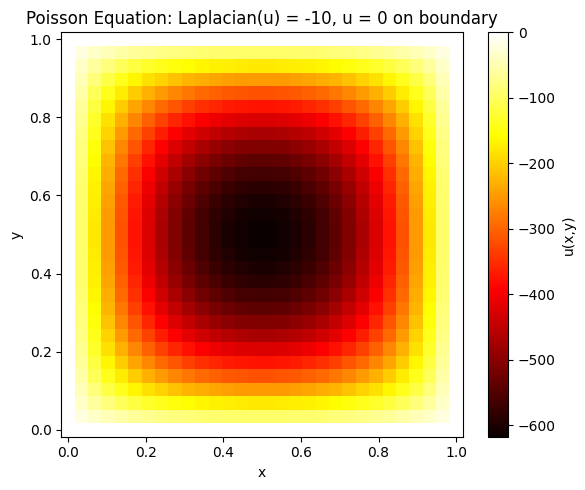

In [11]:
from scipy.sparse.linalg import spsolve

L = grid.laplacian()

# Right-hand side: constant source
rhs = -10 * np.ones(grid.size)

# Dirichlet BC: u = 0 on boundary
# Replace boundary rows with identity
L_bc = L.tolil()
for i in np.where(sel.boundary)[0]:
    L_bc[i, :] = 0
    L_bc[i, i] = 1.0
    rhs[i] = 0.0

u = spsolve(L_bc.tocsr(), rhs).reshape(ny, nx)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.pcolormesh(X, Y, u, cmap='hot', shading='auto')
fig.colorbar(im, ax=ax, label='u(x,y)')
format_plot(ax, title='Poisson Equation: Laplacian(u) = -10, u = 0 on boundary',
            xlabel='x', ylabel='y', grid=False, plotarea='white')
plt.tight_layout()
plt.show()

## 8. Finite Difference Schemes Compared

`Grid2D.gradient()` supports `'forward'`, `'backward'`, and `'central'` schemes.

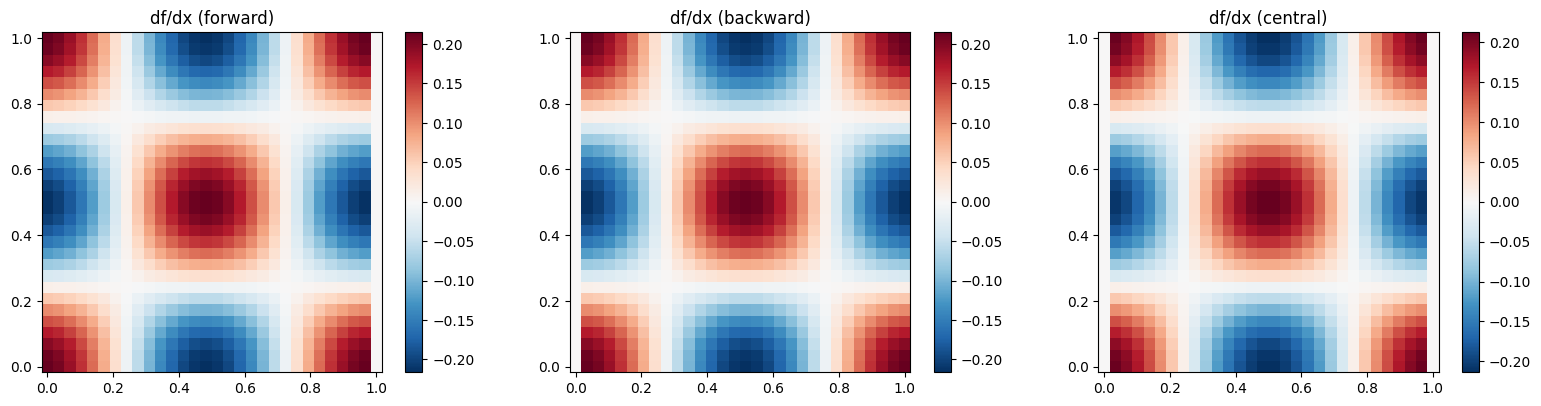

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, scheme in zip(axes, ['forward', 'backward', 'central']):
    Dx_s, _ = grid.gradient(scheme)
    dfx = (Dx_s @ f_flat).reshape(ny, nx)
    im = ax.pcolormesh(X, Y, dfx, cmap='RdBu_r', shading='auto')
    fig.colorbar(im, ax=ax)
    ax.set_title(f'df/dx ({scheme})')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 9. Laplacian Eigenmodes

The eigenvectors of the discrete Laplacian are the vibration modes of the grid.

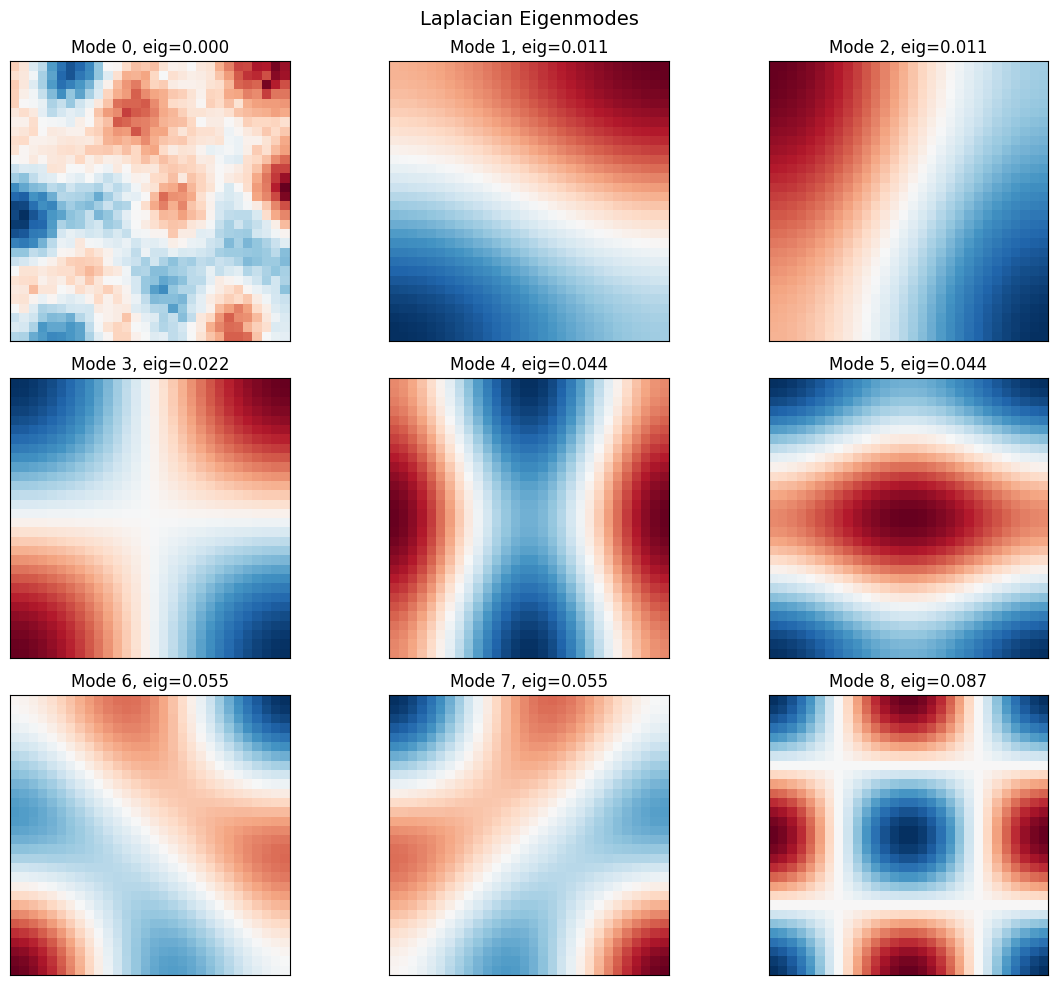

In [13]:
from scipy.sparse.linalg import eigsh as sparse_eigsh

L = grid.laplacian()
# Compute 9 smallest eigenvalues/vectors (first is the constant mode)
vals, vecs = sparse_eigsh(L.astype(float), k=9, which='SM')
vals, vecs = sorteig(vals, vecs)

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i, ax in enumerate(axes.ravel()):
    mode = vecs[:, i].reshape(ny, nx)
    ax.pcolormesh(X, Y, mode, cmap='RdBu_r', shading='auto')
    ax.set_title(f'Mode {i}, eig={vals[i]:.3f}')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Laplacian Eigenmodes', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Vector Field Gallery

Several vector fields plotted with `plot_vecfield`, which color-codes arrows by angle.

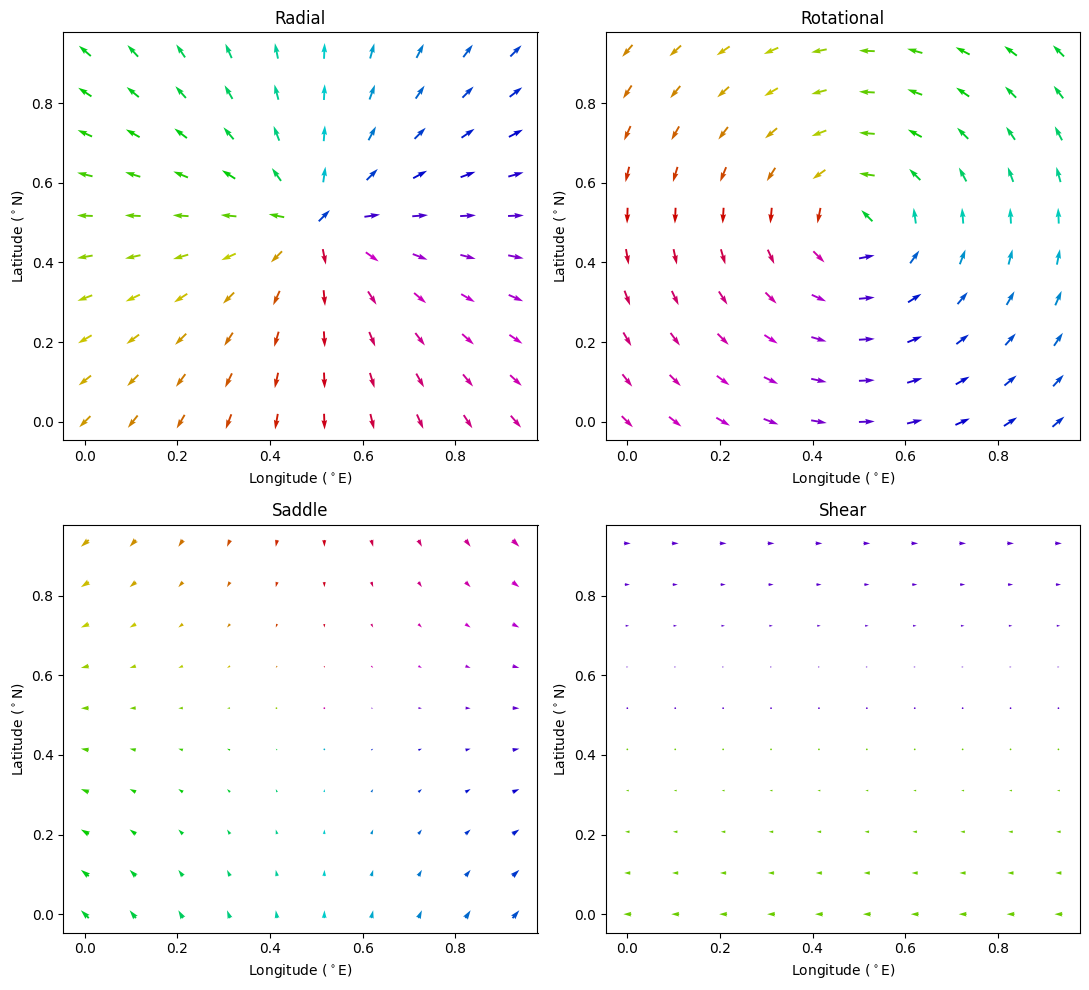

In [14]:
Xc = X - 0.5
Yc = Y - 0.5
r = np.sqrt(Xc**2 + Yc**2)
r[r == 0] = 1  # avoid division by zero

fields = {
    'Radial': (Xc / r, Yc / r),
    'Rotational': (-Yc / r, Xc / r),
    'Saddle': (Xc, -Yc),
    'Shear': (Yc, np.zeros_like(Yc)),
}

fig, axes = plt.subplots(2, 2, figsize=(11, 10))
step = 3

for ax, (name, (U, V)) in zip(axes.ravel(), fields.items()):
    sm = plot_vecfield(ax, X[::step, ::step], Y[::step, ::step],
                       U[::step, ::step], V[::step, ::step],
                       scale=30, width=0.004, title=name)

plt.tight_layout()
plt.show()

## 11. Graph Laplacians: Path and Cycle

`pathlap` and `pathincidence` construct Laplacians and incidence matrices for path and cycle graphs.

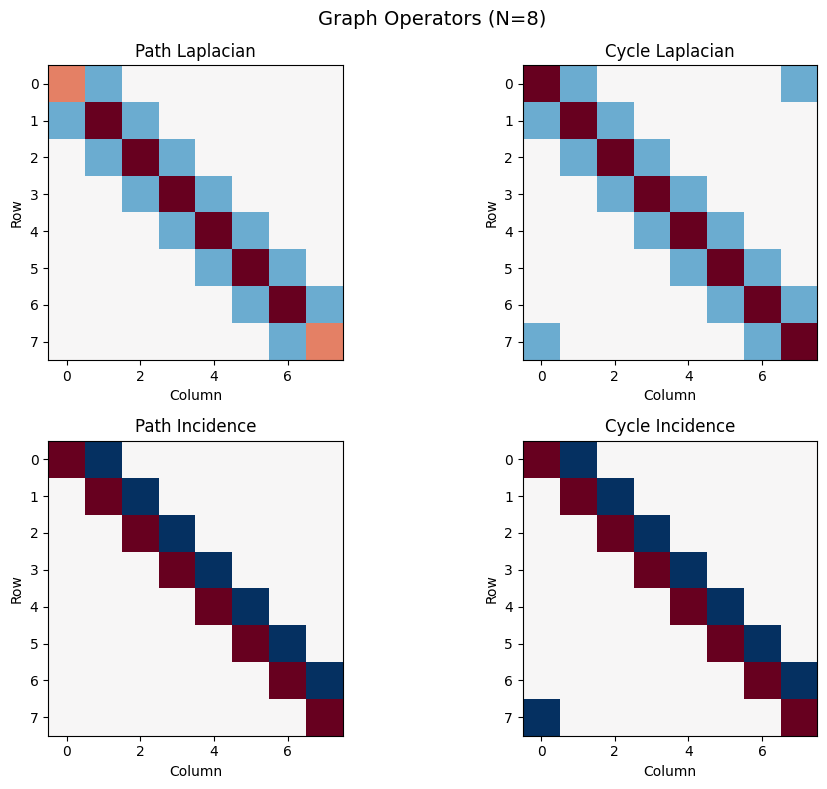

In [15]:
N = 8

L_path = pathlap(N, periodic=False)
L_cycle = pathlap(N, periodic=True)
B_path = pathincidence(N, periodic=False)
B_cycle = pathincidence(N, periodic=True)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].imshow(L_path, cmap='RdBu_r', vmin=-2, vmax=2)
axes[0, 0].set_title('Path Laplacian')

axes[0, 1].imshow(L_cycle, cmap='RdBu_r', vmin=-2, vmax=2)
axes[0, 1].set_title('Cycle Laplacian')

axes[1, 0].imshow(B_path, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_title('Path Incidence')

axes[1, 1].imshow(B_cycle, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 1].set_title('Cycle Incidence')

for ax in axes.ravel():
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

plt.suptitle(f'Graph Operators (N={N})', fontsize=14)
plt.tight_layout()
plt.show()

### Verify L = B @ B.T

For the **cycle** graph, `pathincidence` returns an N x N matrix (N edges), so `B @ B.T`
matches the Laplacian directly. For the **path** graph, only the first N-1 columns
represent real edges.

In [16]:
# Cycle: B is N x N (N edges), so B @ B.T == L directly
L_cycle_check = B_cycle @ B_cycle.T
print("Cycle: L == B @ B.T:", np.allclose(L_cycle, L_cycle_check))

# Path: only first N-1 columns are real edges
B_path_trimmed = B_path[:, :N-1]
L_path_check = B_path_trimmed @ B_path_trimmed.T
print("Path:  L == B[:,:N-1] @ B[:,:N-1].T:", np.allclose(L_path, L_path_check))

Cycle: L == B @ B.T: True
Path:  L == B[:,:N-1] @ B[:,:N-1].T: False


## 12. Normalized Laplacian and Spectral Analysis

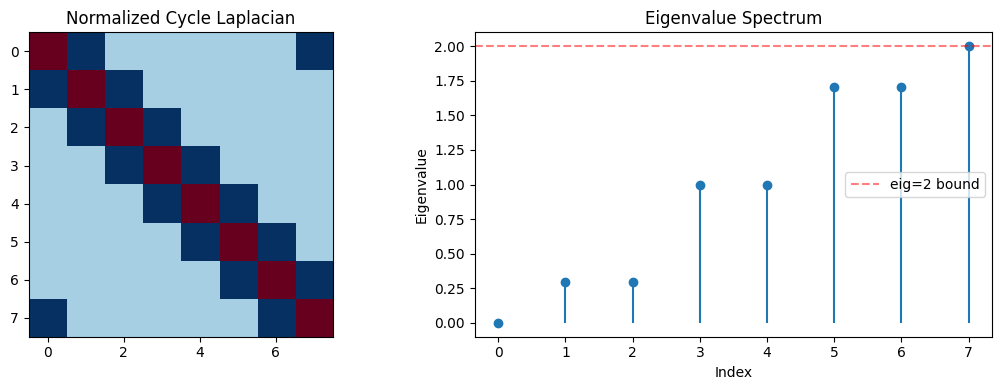

Largest eigenvalue (eigmax): 4.0000


In [17]:
L_norm, D, D_inv = normlap(L_cycle, return_scaling=True)

evals = np.linalg.eigvalsh(L_norm)

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

axes[0].imshow(L_norm, cmap='RdBu_r')
axes[0].set_title('Normalized Cycle Laplacian')

axes[1].stem(evals, basefmt=' ')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Eigenvalue')
axes[1].set_title('Eigenvalue Spectrum')
axes[1].axhline(y=2, color='r', linestyle='--', alpha=0.5, label='eig=2 bound')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Largest eigenvalue (eigmax): {eigmax(L_cycle):.4f}")

## 13. Takagi Factorization

Decomposes a complex symmetric matrix M = U * Sigma * U^T.

In [18]:
# Create a complex symmetric matrix
np.random.seed(42)
A = np.random.randn(4, 4) + 1j * np.random.randn(4, 4)
M = A + A.T  # symmetrize (M = M^T, not M = M^H)

U, sigma = takagi(M)

print("Singular values:", np.round(sigma, 4))

# Verify: M = U @ diag(sigma) @ U.T
M_reconstructed = U @ np.diag(sigma) @ U.T
print(f"Reconstruction error: {np.linalg.norm(M - M_reconstructed):.2e}")

Singular values: [7.1369 5.0195 1.5215 0.8544]
Reconstruction error: 9.38e-15


## 14. Hermitify

Converts a complex symmetric matrix to Hermitian form.

Original symmetric (M = M^T): True
Hermitified (H = H^H):        True


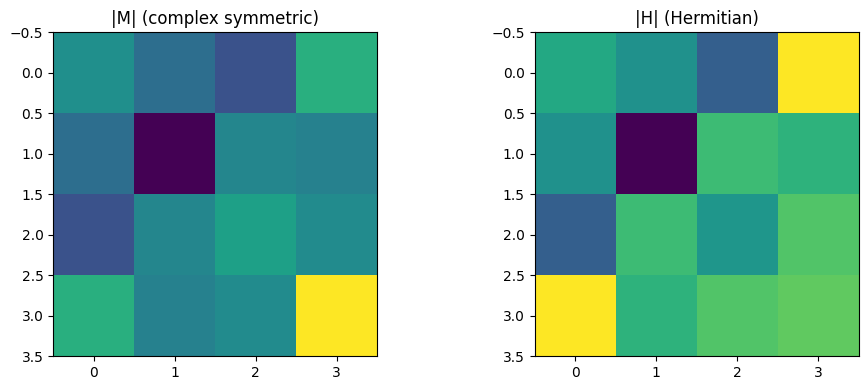

In [19]:
H = hermitify(M)

print("Original symmetric (M = M^T):", np.allclose(M, M.T))
print("Hermitified (H = H^H):       ", np.allclose(H, H.conj().T))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(np.abs(M), cmap='viridis')
axes[0].set_title('|M| (complex symmetric)')
axes[1].imshow(np.abs(H), cmap='viridis')
axes[1].set_title('|H| (Hermitian)')
plt.tight_layout()
plt.show()

## 15. Custom Colormaps

The `darker_hsv_colormap` creates a darker version of the HSV colormap, useful for vector field angle encoding.

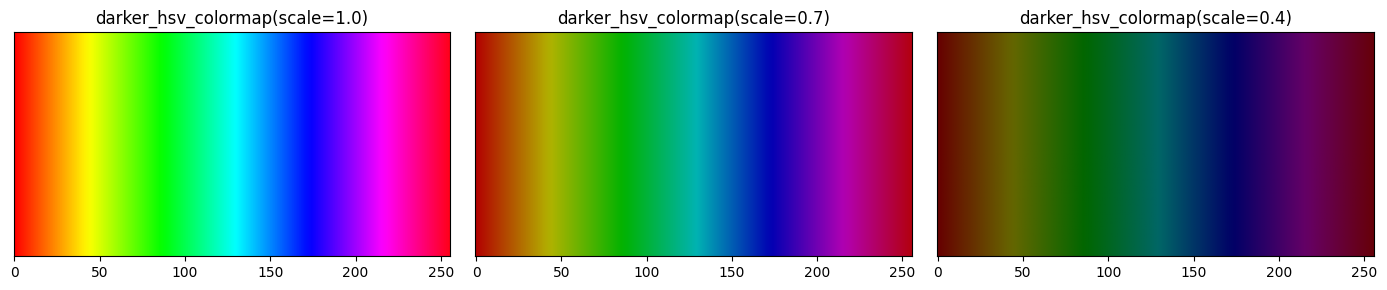

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

gradient = np.linspace(-np.pi, np.pi, 256).reshape(1, -1)

for ax, scale in zip(axes, [1.0, 0.7, 0.4]):
    cmap = darker_hsv_colormap(scale)
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_title(f'darker_hsv_colormap(scale={scale})')
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 16. Physical Constants

The `MU0` constant provides the permeability of free space, used in GIC electric field calculations.

In [21]:
print(f"MU0 = {MU0:.6e} H/m")
print(f"Used in GIC: E = -MU0 * dH/dt")

MU0 = 1.256637e-06 H/m
Used in GIC: E = -MU0 * dH/dt
